This script does the following:
1. Registers neuropixel insert hole locations to ECoG electrodes in space
2. Loads ECoG decoding map
3. Interpolates to estimate the ECoG decoding accuracy at each neuropixel insert hole
4. Saves interpolated results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pd
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft

In [2]:
subjects= ['beignet', 'affi']
np_inserts = ['NPinsert72', 'NPinsert137']
ninserts = len(np_inserts)
np_ecog_mapping_path = [[f"/home/aolab/gdrive/Lab equipment/electrophysiology/Neuropixels/channel_mapping/{insert}_ecog_mapping_{subject}.xlsx" for insert in np_inserts] for subject in subjects]
ecog_signal_path = "/home/aolab/gdrive/Lab equipment/electrophysiology/210910_ecog_signal_path.xlsx"
elec_to_pos = "/home/aolab/gdrive/Lab equipment/electrophysiology/our signal path definitions/244ch_viventi_ecog_elec_to_pos.xlsx"

base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
np_preproc_data_folder = 'np_analysis_preproc_data'

# Different decoding maps to use
dec_map_names = ['all', 'hgamma', 'delta']

save_figs = True
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps"
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelsize']=24
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

# Register neuropixel insert hole locations to ECoG electrodes in space

In [3]:
# Load channel mapping
ecog_signal_path_db = pd.read_excel(ecog_signal_path)
np_ecog_mapping = {}
for subject in subjects:
    np_ecog_mapping[subject] = {}
    np_ecog_mapping[subject]['ecog'] = {}
    np_ecog_mapping[subject]['ecog']['elec_channels'] = np.array(list(range(1,257)), dtype='int')
    np_ecog_mapping[subject]['ecog']['nch'] = len(np_ecog_mapping[subject]['ecog']['elec_channels'])

for isubject, subject in enumerate(subjects):
    for iinsert, insert in enumerate(np_inserts):    
        np_ecog_mapping[subject][insert] = pd.read_excel(np_ecog_mapping_path[isubject][iinsert])

for isubject, subject in enumerate(subjects):
    np_ecog_mapping[subject]['ecog']['elec_pos'], np_ecog_mapping[subject]['ecog']['acq_ch'], np_ecog_mapping[subject]['ecog']['elecs'] = aopy.data.map_acq2pos(ecog_signal_path_db, np_ecog_mapping[subject][np_inserts[0]], np_ecog_mapping[subject]['ecog']['elec_channels'], xpos_name='ecogelec_x', ypos_name='ecogelec_y') # Should be the same for all NP inserts because (0,0) is at the center of the chamber

/home/aolab/projects/Neuropixel_targeting/analyze/aopy/data/base.py:611: UserWarning: Requested acquisition channels [  3   8  38  51  67  72 102 115 131 136 166 179 195 200 230 243] are not connected
  warnings.warn(warning_str)
/home/aolab/projects/Neuropixel_targeting/analyze/aopy/data/base.py:684: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acq_ch_position[ielec,0] = eleclayout_table[xpos_name][eleclayout_table['electrode']==elecid]
/home/aolab/projects/Neuropixel_targeting/analyze/aopy/data/base.py:685: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  acq_ch_position[ielec,1] = eleclayout_table[ypos_name][eleclayout_table['electrode']==elecid]


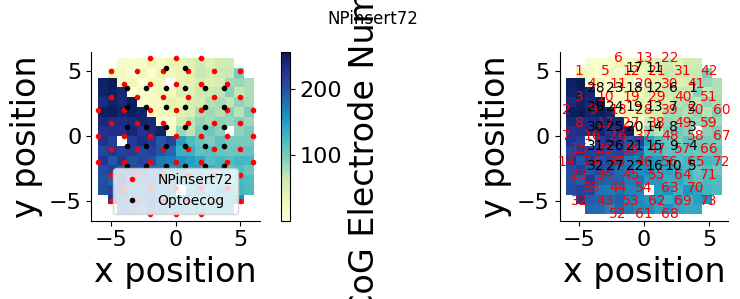

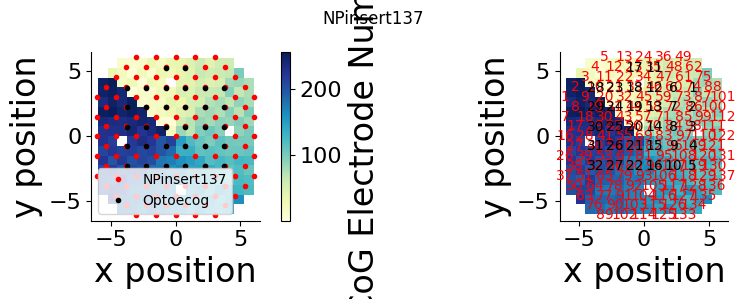

In [4]:
subject = subjects[0]
for iinsert, insert in enumerate(np_inserts):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    data_map = aopy.visualization.get_data_map(np_ecog_mapping[subject]['ecog']['elec_channels'].astype(float)[np_ecog_mapping[subject]['ecog']['acq_ch']-1], np_ecog_mapping[subject]['ecog']['elec_pos'][:,0], np_ecog_mapping[subject]['ecog']['elec_pos'][:,1])
    im = aopy.visualization.plot_spatial_map(data_map, np_ecog_mapping[subject]['ecog']['elec_pos'][:,0], np_ecog_mapping[subject]['ecog']['elec_pos'][:,1], cmap='YlGnBu',nan_color='white', ax=ax[0])
    ax[0].plot(np_ecog_mapping[subject][insert][f"{insert}_x"], np_ecog_mapping[subject][insert][f"{insert}_y"], 'r.', label=f"{insert}")
    ax[0].plot(np_ecog_mapping[subject][insert]['optoecog_x'], np_ecog_mapping[subject][insert]['optoecog_y'], 'k.', label='Optoecog')
    ax[0].set(xlim=(-6.5,6.5), ylim=(-6.5,6.5))
    ax[0].legend()
    cb = plt.colorbar(im, label='ECoG Electrode Number')

    data_map = aopy.visualization.get_data_map(np_ecog_mapping[subject]['ecog']['elec_channels'].astype(float)[np_ecog_mapping[subject]['ecog']['acq_ch']-1], np_ecog_mapping[subject]['ecog']['elec_pos'][:,0], np_ecog_mapping[subject]['ecog']['elec_pos'][:,1])
    im = aopy.visualization.plot_spatial_map(data_map, np_ecog_mapping[subject]['ecog']['elec_pos'][:,0], np_ecog_mapping[subject]['ecog']['elec_pos'][:,1], cmap='YlGnBu', nan_color='white', ax=ax[1])
    [ax[1].annotate(str(np_ecog_mapping[subject][insert]['electrode'][ipt]), (np_ecog_mapping[subject][insert][f"{insert}_x"][ipt], np_ecog_mapping[subject][insert][f"{insert}_y"][ipt]), ha='center', va='center', color='r') for ipt in range(len(np_ecog_mapping[subject][insert][f"{insert}_y"]))]
    [ax[1].annotate(str(np_ecog_mapping[subject][insert]['electrode'][ipt]), (np_ecog_mapping[subject][insert]['optoecog_x'][ipt], np_ecog_mapping[subject][insert]['optoecog_y'][ipt]), ha='center', va='center', color='k') for ipt in range(len(np_ecog_mapping[subject][insert][f"{insert}_y"]))]
    ax[1].set(xlim=(-6.5,6.5), ylim=(-6.5,6.5))
    plt.suptitle(insert)
    fig.tight_layout()
    plt.show()

In [5]:
# Repeat over an approximation of brain areas (for ECoG)
region_idx = {}
region_idx['M1'] = np.array([  42,  46,  49,  52,  53,  54,  55,
        57,  58,  59,  60,  61,  62,  63,  64,  65,   67,  
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131,  134, 135, 136,
       137, 138, 139, 140, 141, 142, 144, 145,  148,
       151,  155, 156,  159, 161])
region_idx['FEF'] = np.array([168, 169, 170, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182,
       183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 198, 199,
       200, 201, 204, 205, 206, 207, 208, 209, 210, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230,
       231, 232, 233, 237, 240, 250])
region_idx['PM']= np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,    33,  34,  
        39,      160, 
       163, 164, 165, 166,  171, 176, 184, 194, 196, 197, 211, 234,
       235, 236, 238, 239, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       251, 252, 253, 254, 255])

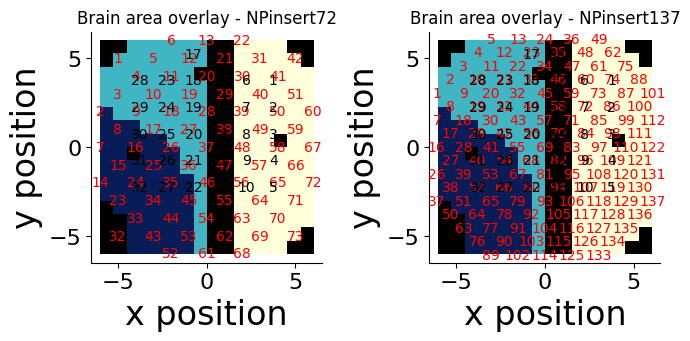

In [6]:
fig, ax = plt.subplots(1,ninserts,figsize=(ninserts*4,3))
for iinsert, insert in enumerate(np_inserts):
    inputdata = np.zeros(np_ecog_mapping[subject]['ecog']['nch'])*np.nan
    inputdata[region_idx['M1']] = 1
    inputdata[region_idx['PM']] = 2
    inputdata[region_idx['FEF']] = 3
    data_map = aopy.visualization.get_data_map(inputdata[np_ecog_mapping[subject]['ecog']['acq_ch']-1], np_ecog_mapping[subject]['ecog']['elec_pos'][:,0], np_ecog_mapping[subject]['ecog']['elec_pos'][:,1])
    im = aopy.visualization.plot_spatial_map(data_map, np_ecog_mapping[subject]['ecog']['elec_pos'][:,0], np_ecog_mapping[subject]['ecog']['elec_pos'][:,1], cmap='YlGnBu', ax=ax[iinsert])
    [ax[iinsert].annotate(str(np_ecog_mapping[subject][insert]['electrode'][ipt]), (np_ecog_mapping[subject][insert][f"{insert}_x"][ipt], np_ecog_mapping[subject][insert][f"{insert}_y"][ipt]), ha='center', va='center', color='r') for ipt in range(len(np_ecog_mapping[subject][insert][f"{insert}_y"]))]
    [ax[iinsert].annotate(str(np_ecog_mapping[subject][insert]['electrode'][ipt]), (np_ecog_mapping[subject][insert]['optoecog_x'][ipt], np_ecog_mapping[subject][insert]['optoecog_y'][ipt]), ha='center', va='center', color='k') for ipt in range(len(np_ecog_mapping[subject][insert][f"{insert}_y"]))]
    ax[iinsert].set(title=f"Brain area overlay - {insert}", xlim=(-6.5,6.5), ylim=(-6.5,6.5))
    if save_figs:
        aopy.visualization.savefig(save_dir, f"{insert} brain_area_mapping_overlay.svg")  

In [7]:
for subject in subjects:
    for insert in np_inserts:
        np_ecog_mapping[subject][f"{insert}_nloc"] = np.sum(~np.isnan(np_ecog_mapping[subject][insert][f"{insert}_x"]))
        np_ecog_mapping[subject][f"{insert}_pts"] = np.array([np_ecog_mapping[subject][insert][f"{insert}_x"][:np_ecog_mapping[subject][f"{insert}_nloc"]], np_ecog_mapping[subject][insert][f"{insert}_y"][:np_ecog_mapping[subject][f"{insert}_nloc"]]]).T
        data_map_ecogch, data_map_ecogch_xy = aopy.visualization.calc_data_map(np_ecog_mapping[subject]['ecog']['elec_channels'].astype(float)[np_ecog_mapping[subject]['ecog']['acq_ch']-1], np_ecog_mapping[subject]['ecog']['elec_pos'][:,0], np_ecog_mapping[subject]['ecog']['elec_pos'][:,1], (len(np.unique(np_ecog_mapping[subject]['ecog']['elec_pos'][:,0])), len(np.unique(np_ecog_mapping[subject]['ecog']['elec_pos'][:,1]))), interp_method='linear')
        np_ecog_mapping[subject][f"{insert}_interp"] = scipy.interpolate.interpn((np.unique(np_ecog_mapping[subject]['ecog']['elec_pos'][:,0]),np.unique(np_ecog_mapping[subject]['ecog']['elec_pos'][:,1])), data_map_ecogch.T, np_ecog_mapping[subject][f"{insert}_pts"], method='linear', bounds_error=False)

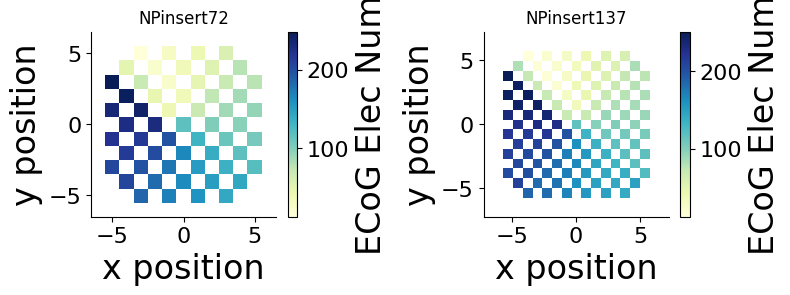

In [8]:
fig, ax = plt.subplots(1,ninserts,figsize=(ninserts*4,3))
for iinsert, insert in enumerate(np_inserts):
    npinsert_interp_datamap = aopy.visualization.get_data_map(np_ecog_mapping[subject][f"{insert}_interp"], np_ecog_mapping[subject][insert][f"{insert}_x"][:np_ecog_mapping[subject][f"{insert}_nloc"]], np_ecog_mapping[subject][insert][f"{insert}_y"][:np_ecog_mapping[subject][f"{insert}_nloc"]])
    im = aopy.visualization.plot_spatial_map(npinsert_interp_datamap, np_ecog_mapping[subject][insert][f"{insert}_x"][:np_ecog_mapping[subject][f"{insert}_nloc"]], np_ecog_mapping[subject][insert][f"{insert}_y"][:np_ecog_mapping[subject][f"{insert}_nloc"]], cmap='YlGnBu', ax=ax[iinsert], nan_color='white')
    cb = plt.colorbar(im, label='ECoG Elec Num')
    ax[iinsert].set_title(f"{insert}")

fig.tight_layout()
plt.show()

# Load decoding accuracy map 

In [9]:
path2data = '/home/aolab/ryan/beignet_analysis/subspace_data/'
stim_site = 7
frequency_band = [(70, 150)]
# days = ['2022-02-14', '2022-02-16', '2022-02-17', '2022-02-18']
# subject = 'beignet'
# subspace_data = {}
# ndays = len(days)
# for iday in range(ndays):
#     temp_file_name = 'stimsite'+str(stim_site)+'_'+days[iday] + '_' + subject + '_subspace_data_power' + str(frequency_band) + '.hdf'
#     subspace_data[days[iday]] = aopy.data.base.load_hdf_group(path2data, temp_file_name)

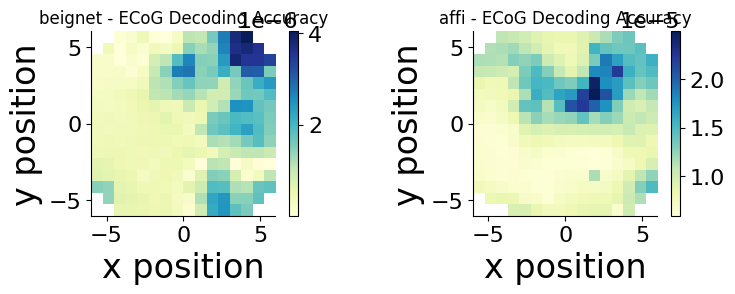

In [10]:
# Load decoding accuracy and plot
dec_map_results = {}
fig, ax = plt.subplots(1,2,figsize=(8,3))
for isubject, subject in enumerate(subjects):
    dec_map_results[subject] = {}
    # dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_decoding_accuracy_all.npz"))

    
    if subject == 'beignet':
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.abs(subspace_data[days[0]]['TRD_tavg'][np_ecog_mapping['ecog']['acq_ch']-1,1]) + np.abs(subspace_data[days[0]]['TRD_tavg'][np_ecog_mapping['ecog']['acq_ch']-1,2])
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.sqrt((subspace_data[days[0]]['TRD_tavg'][np_ecog_mapping['ecog']['acq_ch']-1,1])**2 + (subspace_data[days[0]]['TRD_tavg'][np_ecog_mapping['ecog']['acq_ch']-1,2])**2)
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.abs(subspace_data[days[0]]['TRD_tavg'][np_ecog_mapping['ecog']['acq_ch']-1,1] - subspace_data[days[0]]['TRD_tavg'][np_ecog_mapping['ecog']['acq_ch']-1,2])
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.abs(subspace_data[days[0]]['TRD_tavg'][np_ecog_mapping['ecog']['acq_ch']-1,1])
        # dec_map_results[subject]['ecog_dec_acc_elec_pos'] = np_ecog_mapping['ecog']['elec_pos']
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_cursor_leave_LinRegAll_hgamma.npz")) # High gamma linear regression -- used for AREADNE poster
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_movement_LinRegAll_hgamma.npz")) # High gamma linear regression
        dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_movement_LinRegAll_hgamma.npz")) # High gamma linear regression
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_decoding_accuracy_hgamma.npz")) # High gamma LDA
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_decoding_accuracy_all.npz")) # All frequencies LDA
        dec_map_results[subject]['ecog_dec_acc_elec_pos'] = np.round(dec_map_results[subject]['ecog_decoding_accuracy']['elec_pos'], 8)
        dec_map_results[subject]['ecog_decoding_accuracy'] = dec_map_results[subject]['ecog_decoding_accuracy']['da']
    else: 
        # dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_decoding_accuracy_all.npz"))
        dec_map_results[subject]['ecog_decoding_accuracy'] = np.load(os.path.join(save_dir, f"{subject}_movement_LinRegAll_hgamma.npz")) # High gamma linear regression
        dec_map_results[subject]['ecog_dec_acc_elec_pos'] = np.round(dec_map_results[subject]['ecog_decoding_accuracy']['elec_pos'], 8)
        dec_map_results[subject]['ecog_decoding_accuracy'] = dec_map_results[subject]['ecog_decoding_accuracy']['da']
    
    # Center electrode positions
    dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,0] = dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,0] - np.median(np.unique(dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,0]))
    dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,1] = dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,1] - np.median(np.unique(dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,1]))
    
    dec_map_results[subject]['data_map_ecogch'], dec_map_results[subject]['data_map_ecogch_xy'] = aopy.visualization.calc_data_map(dec_map_results[subject]['ecog_decoding_accuracy'], dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,0], dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,1], (len(np.unique(dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,0])), len(np.unique(dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,1]))), interp_method='linear')
    im = aopy.visualization.plot_spatial_map(dec_map_results[subject]['data_map_ecogch'], dec_map_results[subject]['data_map_ecogch_xy'][0], dec_map_results[subject]['data_map_ecogch_xy'][1], cmap='YlGnBu', ax=ax[isubject], nan_color='white')
    cb = plt.colorbar(im)
    
    ax[isubject].set(title=f"{subject} - ECoG Decoding Accuracy")

fig.tight_layout()
if save_figs:
    aopy.visualization.base.savefig(save_dir, 'ecog_decoding_accuracy_maps.svg')

In [11]:
print(save_dir)

/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps


In [12]:
# dec_map_results[subject]['rec_locations'] @ np.array([[np.cos(np.deg2rad(45)), -np.sin(np.deg2rad(45))],[np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])
# print(np.array([[np.cos(np.deg2rad(60)), -np.sin(np.deg2rad(60))],[np.sin(np.deg2rad(60)), np.cos(np.deg2rad(60))]]))

In [13]:
import matplotlib
aopy.utils.release_memory_limit()
# subject2plot = 'beignet'
subject2plot = 'affi'
cmap_name = 'cool'
# [ 11  30  56   9  47  40  18  11   9 121  48  22   9 120]
site_numbers = {}
site_insert_name = {}
for subject in subjects:
    if subject == 'beignet':
        _, _, preproc_metadata = aopy.data.base.pkl_read(f"{subject}_np_preprocessed", os.path.join(base_save_dir, np_preproc_data_folder))
        # site_numbers[subject] = np.array([ 11,  30,  56,   9,  47,  40,  18,  11,   9, 121,  22,   9, 120, 98, 45]) - 1
        site_numbers[subject] = preproc_metadata['recording_sites'] -1
        site_insert_name[subject] = ['NPinsert72', 'NPinsert72', 'NPinsert72', 'NPinsert72', 'NPinsert72', 'NPinsert72', 'NPinsert72', 'NPinsert72', 'NPinsert72', 
                         'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137']
    elif subject2plot == 'affi':
        _, _,  preproc_metadata = aopy.data.base.pkl_read(f"{subject}_np_preprocessed", os.path.join(base_save_dir, np_preproc_data_folder))
        # site_numbers[subject] = np.array([ 19,  73,  29,  55,  58,  33, 33,  98,  10, 74,  72, 107]) - 1
        site_numbers[subject] = preproc_metadata['recording_sites'] -1
        site_insert_name[subject] = ['NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137',
                           'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137',
                                    'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137','NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137', 'NPinsert137']
# day_colors = ['dodgerblue', 'indigo', 'violet', 'lightblue', 'mediumorchid',
#               'purple', 'steelblue', 'dodgerblue', 'lightblue', 'red', 'black', 'green', 'purple', 'cyan', 'gray', 'yellow'] 
# day_colors = 


In [14]:
for subject in subjects:
    dec_map_results[subject]['rec_locations'] = np.array([[np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_x"][site], np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_y"][site]] for isite, site in enumerate(site_numbers[subject])])
    if subject == 'affi':
        dec_map_results[subject]['rc_axis_angle'] = np.deg2rad(15) # rotates 'x-axis' by this much
        dec_map_results[subject]['rc_axis'] = dec_map_results[subject]['rec_locations'] @ np.array([[np.cos(dec_map_results[subject]['rc_axis_angle']), -np.sin(dec_map_results[subject]['rc_axis_angle'])],[np.sin(dec_map_results[subject]['rc_axis_angle']), np.cos(dec_map_results[subject]['rc_axis_angle'])]])
        
    elif subject == 'beignet':
        dec_map_results[subject]['rc_axis_angle'] = 0 # rotates 'x-axis' by this much
        dec_map_results[subject]['rc_axis'] = dec_map_results[subject]['rec_locations'] @ np.array([[np.cos(dec_map_results[subject]['rc_axis_angle']), -np.sin(dec_map_results[subject]['rc_axis_angle'])],[np.sin(dec_map_results[subject]['rc_axis_angle']), np.cos(dec_map_results[subject]['rc_axis_angle'])]])
    
    
    # map_min = np.min(np.max(dec_map_results[subject]['rc_axis'][:,0]))
    map_min = np.min(dec_map_results[subject]['rc_axis'][:,0])
    map_min_val = 0.25
    map_range = np.max(dec_map_results[subject]['rc_axis'][:,0]) - np.min(dec_map_results[subject]['rc_axis'][:,0])
    day_colors = [matplotlib.colormaps[cmap_name](((dec_map_results[subject]['rc_axis'][irec,0]+np.abs(map_min))/map_range)*(1-map_min_val)+map_min_val)[:3] for irec in range(dec_map_results[subject]['rc_axis'].shape[0])]
    dec_map_results[subject]['day_colors']=day_colors

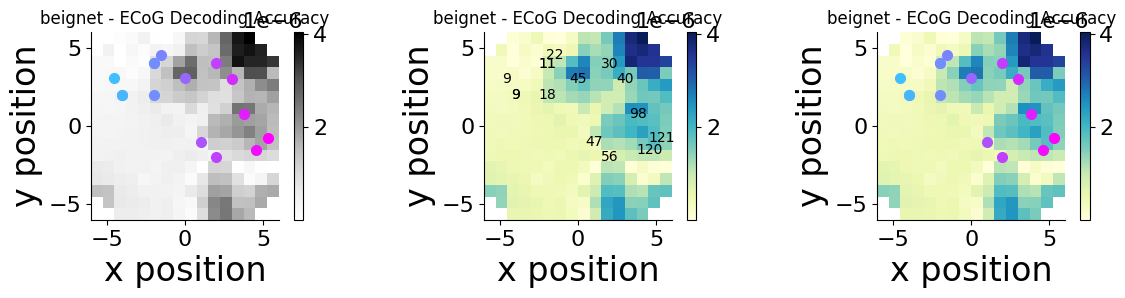

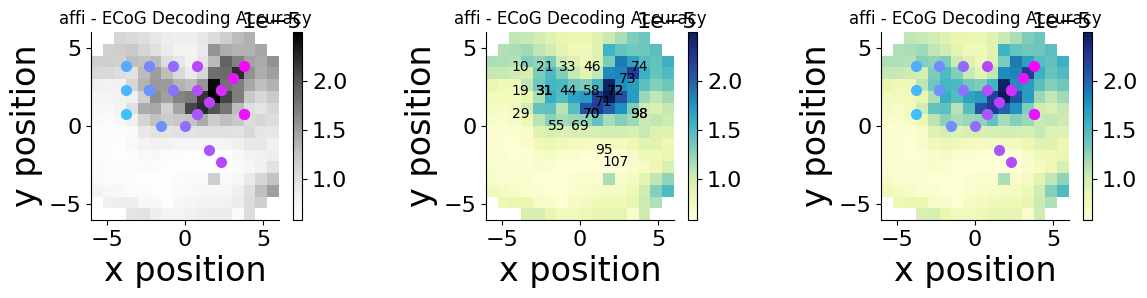

In [25]:
# Repeat plots with dots at specified lcoations
site_label_color= 'r'
# dec_map_results[subject2plot]['rec_locations'] = np.array([[np_ecog_mapping[site_insert_name[isite]][f"{site_insert_name[isite]}_x"][site], np_ecog_mapping[site_insert_name[isite]][f"{site_insert_name[isite]}_y"][site]] for isite, site in enumerate(site_numbers)])
# Plot decoding accuracy
for subject in subjects:
    fig, ax = plt.subplots(1,3,figsize=(12,3))
    dec_map_results[subject]['data_map_ecogch'], dec_map_results[subject]['data_map_ecogch_xy'] = aopy.visualization.calc_data_map(dec_map_results[subject]['ecog_decoding_accuracy'], dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,0], dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,1], (len(np.unique(dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,0])), len(np.unique(dec_map_results[subject]['ecog_dec_acc_elec_pos'][:,1]))), interp_method='linear')
    im = aopy.visualization.plot_spatial_map(dec_map_results[subject]['data_map_ecogch'], dec_map_results[subject]['data_map_ecogch_xy'][0], dec_map_results[subject]['data_map_ecogch_xy'][1], cmap='Greys', ax=ax[0], nan_color='white')
    cb = plt.colorbar(im)
    # ax[0].set_aspect('equal')

    # Label relevant dots
    [ax[0].plot(np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_x"][site], np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_y"][site], '.', color=dec_map_results[subject]['day_colors'][isite], markersize=14) for isite, site in enumerate(site_numbers[subject])]
    ax[0].set(title=f"{subject} - ECoG Decoding Accuracy")
    ax[0].set(xlim=(-6,6), ylim=(-6,6))

    im = aopy.visualization.plot_spatial_map(dec_map_results[subject]['data_map_ecogch'], dec_map_results[subject]['data_map_ecogch_xy'][0], dec_map_results[subject]['data_map_ecogch_xy'][1], cmap='YlGnBu', ax=ax[1], nan_color='white')
    cb = plt.colorbar(im)

    # Label relevant dots
    [ax[1].annotate(f"{site_numbers[subject][isite]+1}", (np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_x"][site], np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_y"][site]),ha='center', va='center', ) for isite, site in enumerate(site_numbers[subject])]
    ax[1].set(title=f"{subject} - ECoG Decoding Accuracy")
    ax[1].set(xlim=(-6,6), ylim=(-6,6))

    # Label relevant dots
    [ax[2].plot(np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_x"][site], np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_y"][site], '.', color=dec_map_results[subject]['day_colors'][isite], markersize=14) for isite, site in enumerate(site_numbers[subject])]
    ax[2].set(title=f"{subject} - ECoG Decoding Accuracy")
    ax[2].set(xlim=(-6,6), ylim=(-6,6))

    im = aopy.visualization.plot_spatial_map(dec_map_results[subject]['data_map_ecogch'], dec_map_results[subject]['data_map_ecogch_xy'][0], dec_map_results[subject]['data_map_ecogch_xy'][1], cmap='YlGnBu', ax=ax[2], nan_color='white')
    cb = plt.colorbar(im)

    fig.tight_layout()
    if save_figs:
        aopy.visualization.base.savefig(save_dir, f'{subject2plot}_ecog_decoding_accuracy_maps_site_label.svg')

# Interpolate

In [16]:
# print(dec_map_results['affi'][f"{np_inserts[1]}_interp"][site_numbers['affi']])
# print(site_numbers['affi'][np.argsort(dec_map_results['affi'][f"{np_inserts[1]}_interp"][site_numbers['affi']])])

In [17]:
# Interpolate decoding accuracy map - nans first
for isubject, subject in enumerate(subjects):
    for iinsert, insert in enumerate(np_inserts):
        dec_map_results[subject][f"{insert}_interp"] = scipy.interpolate.interpn((np.unique(dec_map_results[subject]['data_map_ecogch_xy'][0]),np.unique(dec_map_results[subject]['data_map_ecogch_xy'][1])), dec_map_results[subject]['data_map_ecogch'].T, np_ecog_mapping[subject][f"{insert}_pts"], method='linear', bounds_error=False)

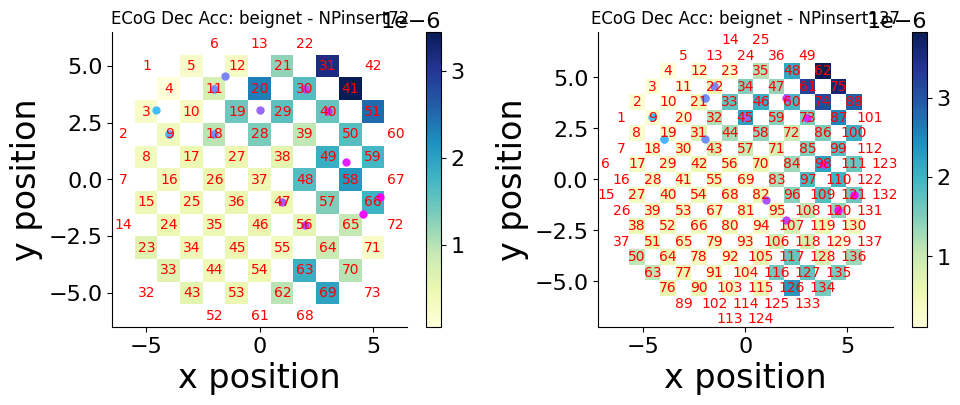

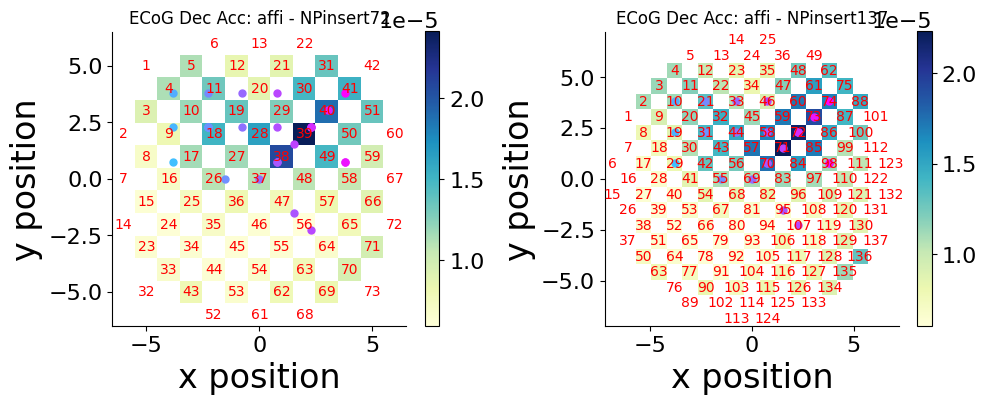

In [18]:
for isubject, subject in enumerate(subjects):
    fig, ax = plt.subplots(1,ninserts,figsize=(5*ninserts,4))
    for iinsert, insert in enumerate(np_inserts):
        npinsert_interp_datamap = aopy.visualization.get_data_map(dec_map_results[subject][f"{insert}_interp"], np_ecog_mapping[subject][insert][f"{insert}_x"][:np_ecog_mapping[subject][f"{insert}_nloc"]], np_ecog_mapping[subject][insert][f"{insert}_y"][:np_ecog_mapping[subject][f"{insert}_nloc"]])
        im = aopy.visualization.plot_spatial_map(npinsert_interp_datamap, np_ecog_mapping[subject][insert][f"{insert}_x"][:np_ecog_mapping[subject][f"{insert}_nloc"]], np_ecog_mapping[subject][insert][f"{insert}_y"][:np_ecog_mapping[subject][f"{insert}_nloc"]], cmap='YlGnBu', ax=ax[iinsert], nan_color='white')
        cb = plt.colorbar(im)
        ax[iinsert].set(title=f"ECoG Dec Acc: {subject} - {insert}")
        [ax[iinsert].annotate(str(np_ecog_mapping[subject][insert]['electrode'][ipt]), (np_ecog_mapping[subject][insert][f"{insert}_x"][ipt], np_ecog_mapping[subject][insert][f"{insert}_y"][ipt]), ha='center', va='center', color='r') for ipt in range(len(np_ecog_mapping[subject][insert][f"{insert}_y"]))]
    
        # if subject == 'beignet':
        [ax[iinsert].plot(np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_x"][site], np_ecog_mapping[subject][site_insert_name[subject][isite]][f"{site_insert_name[subject][isite]}_y"][site], '.', color=dec_map_results[subject]['day_colors'][isite], markersize=10) for isite, site in enumerate(site_numbers[subject])]
    
    fig.tight_layout()
    plt.show()

# Save interpolated results

In [19]:
print(dec_map_results['affi'][f"{insert}_interp"][106])
print(dec_map_results['affi'][f"{insert}_interp"][9])
print(dec_map_results['affi'][f"{insert}_interp"][72])
print(dec_map_results['beignet'][f"{insert}_interp"][120])
print(dec_map_results['beignet'][f"{insert}_interp"][47])
print(dec_map_results['beignet'].keys())
print(dec_map_results['beignet']['ecog_dec_acc_elec_pos'].shape)
print(dec_map_results['affi']['rec_locations'].shape)
print(np.array(dec_map_results['affi']['day_colors']))

6.042015732902905e-06
1.1132375505834886e-05
1.9091554276866786e-05
1.6291687267839329e-06
2.142761606010598e-06
dict_keys(['ecog_decoding_accuracy', 'ecog_dec_acc_elec_pos', 'data_map_ecogch', 'data_map_ecogch_xy', 'rec_locations', 'rc_axis_angle', 'rc_axis', 'day_colors', 'NPinsert72_interp', 'NPinsert137_interp'])
(238, 2)
(26, 2)
[[0.28627451 0.71372549 1.        ]
 [0.25098039 0.74901961 1.        ]
 [0.43529412 0.56470588 1.        ]
 [0.69411765 0.30588235 1.        ]
 [0.59215686 0.40784314 1.        ]
 [0.92941176 0.07058824 1.        ]
 [0.32156863 0.67843137 1.        ]
 [1.         0.         1.        ]
 [0.83137255 0.16862745 1.        ]
 [0.72156863 0.27843137 1.        ]
 [0.65882353 0.34117647 1.        ]
 [0.55686275 0.44313725 1.        ]
 [0.92941176 0.07058824 1.        ]
 [0.72941176 0.27058824 1.        ]
 [0.41960784 0.58039216 1.        ]
 [0.74509804 0.25490196 1.        ]
 [0.45882353 0.54117647 1.        ]
 [0.57254902 0.42745098 1.        ]
 [0.67058824 0.3

In [20]:
print(save_dir)

/media/moor-data/results/Ryan/neuropixel_targeting/ecog_decoding_maps


In [21]:
[aopy.data.base.save_hdf(save_dir, 'npinsert_ecog_decoding', dec_map_results[subject], data_group=subject, append=True) for subject in subjects]

[None, None]

In [22]:
aopy.data.base.get_hdf_dictionary(save_dir, 'npinsert_ecog_decoding', show_tree=True)

npinsert_ecog_decoding
└──affi
|  └──NPinsert137_interp: [shape: (137,), type: float64]
|  └──NPinsert72_interp: [shape: (73,), type: float64]
|  └──data_map_ecogch: [shape: (16, 16), type: float64]
|  └──data_map_ecogch_xy: [shape: (2, 256), type: float64]
|  └──day_colors: [shape: (26, 3), type: float64]
|  └──ecog_dec_acc_elec_pos: [shape: (233, 2), type: float64]
|  └──ecog_decoding_accuracy: [shape: (233,), type: float64]
|  └──rc_axis: [shape: (26, 2), type: float64]
|  └──rc_axis_angle: [shape: (), type: float64]
|  └──rec_locations: [shape: (26, 2), type: float64]
└──beignet
|  └──NPinsert137_interp: [shape: (137,), type: float64]
|  └──NPinsert72_interp: [shape: (73,), type: float64]
|  └──data_map_ecogch: [shape: (16, 16), type: float64]
|  └──data_map_ecogch_xy: [shape: (2, 256), type: float64]
|  └──day_colors: [shape: (15, 3), type: float64]
|  └──ecog_dec_acc_elec_pos: [shape: (238, 2), type: float64]
|  └──ecog_decoding_accuracy: [shape: (238,), type: float64]
|  └──rc_a

{'affi': {'NPinsert137_interp': ((137,), dtype('<f8')),
  'NPinsert72_interp': ((73,), dtype('<f8')),
  'data_map_ecogch': ((16, 16), dtype('<f8')),
  'data_map_ecogch_xy': ((2, 256), dtype('<f8')),
  'day_colors': ((26, 3), dtype('<f8')),
  'ecog_dec_acc_elec_pos': ((233, 2), dtype('<f8')),
  'ecog_decoding_accuracy': ((233,), dtype('<f8')),
  'rc_axis': ((26, 2), dtype('<f8')),
  'rc_axis_angle': ((), dtype('<f8')),
  'rec_locations': ((26, 2), dtype('<f8'))},
 'beignet': {'NPinsert137_interp': ((137,), dtype('<f8')),
  'NPinsert72_interp': ((73,), dtype('<f8')),
  'data_map_ecogch': ((16, 16), dtype('<f8')),
  'data_map_ecogch_xy': ((2, 256), dtype('<f8')),
  'day_colors': ((15, 3), dtype('<f8')),
  'ecog_dec_acc_elec_pos': ((238, 2), dtype('<f8')),
  'ecog_decoding_accuracy': ((238,), dtype('<f8')),
  'rc_axis': ((15, 2), dtype('<f8')),
  'rc_axis_angle': ((), dtype('int64')),
  'rec_locations': ((15, 2), dtype('<f8'))}}